In [44]:
!pip install pandas scikit-learn nltk matplotlib wordcloud joblib gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 100.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
t

In [67]:
import pandas as pd
import re
import joblib
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import gradio as gr

# Загрузка ресурсов NLTK
nltk.download(['punkt', 'wordnet', 'stopwords', 'punkt_tab'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [68]:
!pip install kaggle
from google.colab import files
files.upload()  # Загрузите kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d uciml/sms-spam-collection-dataset
!unzip sms-spam-collection-dataset.zip


Saving sms-spam-collection-dataset-metadata.json to sms-spam-collection-dataset-metadata (3).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset
License(s): unknown
sms-spam-collection-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  sms-spam-collection-dataset.zip
replace spam.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [69]:
df = pd.read_csv("spam.csv", encoding='latin-1')

In [70]:
df = df.iloc[:, :-3]# удаляем 3 последних стобца столбца

df = df.rename(columns={'v1': 'label', 'v2': 'text'})# переименовываем
df

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [71]:
def preprocess_text(text):
    # Удаляем все кроме букв и пробелов
    text = re.sub(r'[^a-zA-Z]', ' ', text).lower()

    # Токенизация (разбиение на отдельные слова)
    tokens = nltk.word_tokenize(text)

    # Лемматизация (приведение к нормальной форме)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Удаление стоп-слов (местоимения, предлоги и т.д.)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    return ' '.join(tokens)

# Применяем обработку ко всем текстам
df['cleaned_text'] = df['text'].apply(preprocess_text)

In [72]:
# Создаем TF-IDF векторайзер (преобразует текст в числа)
tfidf = TfidfVectorizer(max_features=5000)

# Применяем к очищенным текстам
X = tfidf.fit_transform(df['cleaned_text'])
y = df['label'].map({'ham': 0, 'spam': 1})

# Сохраняем векторайзер для будущих предсказаний
joblib.dump(tfidf, 'tfidf_vectorizer.joblib')

['tfidf_vectorizer.joblib']

In [74]:
# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=228
)

# Инициализируем модель Наивного Байеса
model = MultinomialNB()
model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred = model.predict(X_test)
# Оценка точности
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
# Сохраняем модель
joblib.dump(model, 'spam_model.joblib')

Accuracy: 0.97


['spam_model.joblib']

<Figure size 600x600 with 0 Axes>

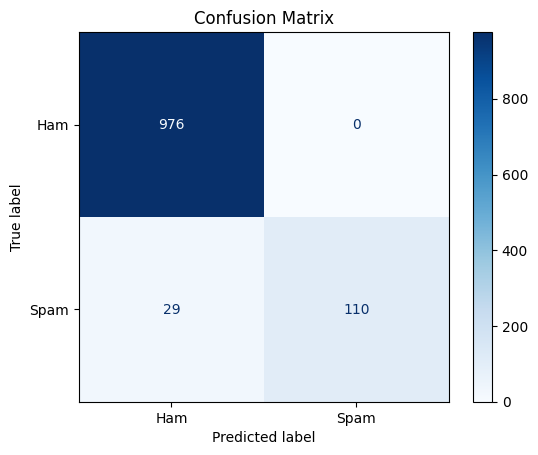

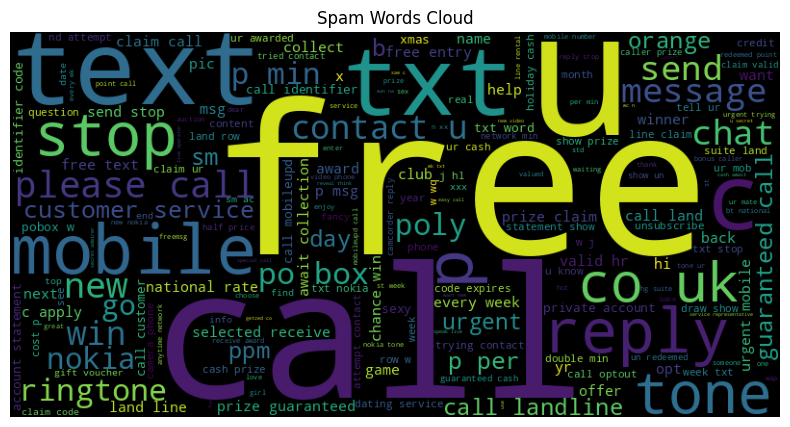

In [75]:
# Матрица ошибок
plt.figure(figsize=(6,6))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Ham', 'Spam'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
# Облако слов для спама
spam_words = ' '.join(df[df['label'] == 'spam']['cleaned_text'])
wordcloud = WordCloud(width=800, height=400).generate(spam_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.title('Spam Words Cloud')
plt.axis('off')
plt.show()

In [76]:
# Загрузка сохраненных модели и векторайзера
model = joblib.load('spam_model.joblib')
tfidf = joblib.load('tfidf_vectorizer.joblib')

# Функция для предсказания
def predict_spam(text):
    # Предобработка текста
    cleaned_text = preprocess_text(text)
    # Векторизация
    text_vector = tfidf.transform([cleaned_text])
    # Предсказание
    prediction = model.predict(text_vector)[0]
    return "СПАМ" if prediction == 1 else "НЕ СПАМ"



In [80]:
while True:
  print('Введите сообщение для проверки (или exit для выхода)')
  vvod=input()
  if vvod=='exit':
    print("До свидания!")
    break
  else:
    print('Результат анализа:')
    print('Исходный текст:',vvod)
    print('Очищенный текст:',preprocess_text(vvod))
    print('Итог',predict_spam(vvod))
#пример SPAM WINNER!! You are the lucky winner of $1,000,000!

Введите сообщение для проверки (или exit для выхода)
exit
До свидания!
